## Graph Analytics with ArangoDB (Python-Arango Library) (Part 1)

### Install Required Libraries

In [ ]:
!pip3 install --upgrade pip

In [ ]:
%pip install python-arango
%pip install networkx
%pip install numpy
%pip install scipy
%pip install tabulate
%pip install matplotlib
%pip install geopandas

### Library Imports

In [3]:
import sys
from arango import ArangoClient
import networkx as nx
import pkg_resources
import numpy as np
import scipy
from tabulate import tabulate
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import csv

### Library Versions

In [4]:
l = 15
r = 14

arango_version = pkg_resources.get_distribution("python-arango").version

print("Software & Library Versions".center(l+r))
print('-'* (l + 1) + '|' + '-' * (r - 2))
print('Python'.rjust(l), '|', sys.version[0:6])
print('Arango Client'.rjust(l), '|', arango_version)
print('NetworkX'.rjust(l), '|', nx.__version__)
print('NumPy'.rjust(l), '|', np.__version__)
print('SciPy'.rjust(l), '|', scipy.__version__)
print('Matplotlib'.rjust(l), '|', matplotlib.__version__)

 Software & Library Versions 
----------------|------------
         Python | 3.11.4
  Arango Client | 8.1.2
       NetworkX | 3.4.2
          NumPy | 2.1.3
          SciPy | 1.14.1
     Matplotlib | 3.9.3


### Import Dataset

In [5]:
# Connect to ArangoDB
client = ArangoClient()
db = client.db('_system', username='root', password='testpassword')

# Access collections
nodes = db.collection('airports')
edges = db.collection('flights')

# Fetch graph data
graph_data = {
    'nodes': list(nodes.all()),
    'edges': list(edges.all())
}

flightGraph = nx.MultiDiGraph()

# Add nodes
for node in graph_data['nodes']:
    flightGraph.add_node(node['_key'], **node)

# Add edges
for edge in graph_data['edges']:
    flightGraph.add_edge(
        edge['_from'].split('/')[-1],
        edge['_to'].split('/')[-1],
        **edge
    )

### Some Introductory Commands

#### Show Number of Airports

In [6]:
query = """
FOR airport IN airports
    COLLECT WITH COUNT INTO numAirports
RETURN { NumberOfAirports: numAirports }
"""
result = db.aql.execute(query)
print(list(result))

[{'NumberOfAirports': 365}]


#### Show the Number of Flights

In [7]:
query = """
FOR flight IN flights
    COLLECT WITH COUNT INTO numFlights
RETURN { NumberOfFlights: numFlights }
"""
result = db.aql.execute(query)

print(list(result))

[{'NumberOfFlights': 992298}]


#### Add Airline Names for Each Airline Code

In [8]:
# Load CSV file
with open('../import/airlines.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        query = """
        FOR flight IN flights
            FILTER flight.airline_id == @airline_id
            UPDATE flight WITH {
                airline_name: @airline_name,
                airline_code: @airline_code
            } IN flights
        """
        db.aql.execute(query, bind_vars={
            'airline_id': row['airline_id'],
            'airline_name': row['airline_name'],
            'airline_code': row['airline_code']
        })

#### Add Airport Name, City, & State

In [9]:
with open('../import/airports.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        query = """
        FOR airport IN airports
            FILTER airport.unique_id == @unique_id
            UPDATE airport WITH {
                airport_code: @airport_code,
                airport_name: @airport_name,
                airport_city: @city_name,
                airportState_code: @state,
                airportState_name: @state_name
            } IN airports
        """
        db.aql.execute(query, bind_vars={
            'unique_id': row['unique_id'],
            'airport_code': row['airport_code'],
            'airport_name': row['airport_name'],
            'city_name': row['city_name'],
            'state': row['state'],
            'state_name': row['state_name']
        })

#### Return Name of Airline With ID of '2'

In [10]:
query = """
FOR flight IN flights
    FILTER flight.airline_id == '2'
    RETURN DISTINCT {
        AirlineName: flight.airline_name,
        AirlineCode: flight.airline_code
    }
"""

result = db.aql.execute(query)
result = list(result)


headers = ["Airline", "Airline Code"]
table_data = [[row["AirlineName"], row["AirlineCode"]] for row in result]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------------------+----------------+
| Airline                | Airline Code   |
+========================+================+
| ATA Airlines d/b/a ATA | TZ             |
+------------------------+----------------+


#### Count Number of Flights for Each Carrier

In [11]:
query = """
FOR flight IN flights
    COLLECT airline_name = flight.airline_name, airline_code = flight.airline_code WITH COUNT INTO numFlights
    SORT numFlights DESC
    RETURN {
        Airline: airline_name,
        AirlineCode: airline_code,
        Number_of_Flights: numFlights
    }
"""

result = db.aql.execute(query)
result = list(result)

headers = ["Airline", "Airline Code", "Number of FLights"]
table_data = [[row["Airline"], row["AirlineCode"], row["Number_of_Flights"]] for row in result]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------------------------+----------------+---------------------+
| Airline                      | Airline Code   |   Number of FLights |
+==============================+================+=====================+
| Southwest Airlines Co.       | WN             |              167493 |
+------------------------------+----------------+---------------------+
| Delta Air Lines Inc.         | DL             |              135194 |
+------------------------------+----------------+---------------------+
| American Airlines Inc.       | AA             |              110625 |
+------------------------------+----------------+---------------------+
| United Air Lines Inc.        | UA             |               98318 |
+------------------------------+----------------+---------------------+
| US Airways Inc.              | US             |               89157 |
+------------------------------+----------------+---------------------+
| Northwest Airlines Inc.      | NW             |               

#### Return Airport With ID of '33'

In [12]:
query = """
FOR airport IN airports
    FILTER airport.unique_id == '33'
    RETURN {
        AirportName: airport.airport_name
    }
"""
result = db.aql.execute(query)
result = list(result)

headers = ["AirportName"]
table_data = [[row["AirportName"]] for row in result]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------------------------------------+
| AirportName                              |
+==========================================+
| Jackson Medgar Wiley Evers International |
+------------------------------------------+


#### Return List of Unique Airline Codes & Names

In [13]:
query = """
FOR flight IN flights
    COLLECT AirlineCode = flight.airline_code, AirlineName = flight.airline_name
    RETURN {
        AirlineCode: AirlineCode,
        AirlineName: AirlineName
    }
"""

result = db.aql.execute(query)
result = list(result)

headers = ["Airline Name", "Airline Code"]
table_data = [[row["AirlineName"], row["AirlineCode"]] for row in result]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------------------------+----------------+
| Airline Name                 | Airline Code   |
+==============================+================+
| Endeavor Air Inc.            | 9E             |
+------------------------------+----------------+
| American Airlines Inc.       | AA             |
+------------------------------+----------------+
| Alaska Airlines Inc.         | AS             |
+------------------------------+----------------+
| JetBlue Airways              | B6             |
+------------------------------+----------------+
| Continental Air Lines Inc.   | CO             |
+------------------------------+----------------+
| Independence Air             | DH             |
+------------------------------+----------------+
| Delta Air Lines Inc.         | DL             |
+------------------------------+----------------+
| ExpressJet Airlines Inc.     | EV             |
+------------------------------+----------------+
| Frontier Airlines Inc.       | F9             |


#### Show 25 Airports and Their Data

In [14]:
query = """
FOR airport IN airports
    LIMIT 25
    SORT airport.airport_code
    RETURN {
        AirportCode: airport.airport_code,
        AirportName: airport.airport_name,
        City: airport.airport_city,
        StateCode: airport.airportState_code,
        StateName: airport.airportState_name
    }
"""

result = db.aql.execute(query)
result = list(result)

headers = ["Airport Code",
        "Airport Name",
        "City",
        "State Code",
        "State Name"]

table_data = [[row["AirportCode"], row["AirportName"], row["City"], row["StateCode"], row["StateName"]] for row in result]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+----------------+--------------------------------------------+----------------------------+--------------+----------------+
| Airport Code   | Airport Name                               | City                       | State Code   | State Name     |
+================+============================================+============================+==============+================+
| AGS            | Augusta Regional at Bush Field             | Augusta                    | GA           | Georgia        |
+----------------+--------------------------------------------+----------------------------+--------------+----------------+
| AMA            | Rick Husband Amarillo International        | Amarillo                   | TX           | Texas          |
+----------------+--------------------------------------------+----------------------------+--------------+----------------+
| ANI            | Aniak Airport                              | Aniak                      | AK           | Alaska         |


#### Display Full (Relevant) Flight Details for 25 Flights

In [15]:
query = """
FOR flight IN flights
    FOR origin IN airports FILTER flight._from == origin._id
    FOR destination IN airports FILTER flight._to == destination._id
    LIMIT 25
    RETURN {
        Origin: origin.airport_name,
        Airline: flight.airline_name,
        FlightNumber: flight.flight_number,
        FlightDistance: flight.flight_distance,
        ScheduledDepartTime: flight.departure_datetime,
        ScheduledArrivalTime: flight.arrival_datetime,
        Destination: destination.airport_name
    }
"""

result = db.aql.execute(query)
result = list(result)

headers = ["Origin",
        "Airline",
        "Flight Number",
        "Flight Distance (in Miles)",
        "Scheduled Departure Time",
        "Scheduled Arrival Time",
        "Destination"]

table_data = [
    [
        row["Origin"],
        row["Airline"],
        row["FlightNumber"],
        row["FlightDistance"],
        row["ScheduledDepartTime"],
        row["ScheduledArrivalTime"],
        row["Destination"]
    ] 
        for row in result
    ]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+--------------------------+----------------------+-----------------+------------------------------+----------------------------+----------------------------+--------------------------------------------+
| Origin                   | Airline              |   Flight Number |   Flight Distance (in Miles) | Scheduled Departure Time   | Scheduled Arrival Time     | Destination                                |
+==========================+======================+=================+==============================+============================+============================+============================================+
| Fort Wayne International | Comair Inc.          |            6340 |                          128 | 2010-05-13T15:45:00.000000 | 2010-05-13T16:58:00.000000 | Detroit Metro Wayne County                 |
+--------------------------+----------------------+-----------------+------------------------------+----------------------------+----------------------------+--------------------------

#### Calculate & Display the Duration of Each of the Flights (Show 25)

In [16]:
query = """
FOR flight IN flights
    FOR origin IN airports FILTER flight._from == origin._id
    FOR destination IN airports FILTER flight._to == destination._id
    LET flight_duration = DATE_DIFF(flight.departure_datetime, flight.arrival_datetime, "minutes")
    LIMIT 25
    RETURN {
        Origin: origin.airport_name,
        FlightDuration: flight_duration,
        Destination: destination.airport_name,
        FlightNumber: flight.flight_number,
        AirlineName: flight.airline_name,
        FlightDistance: flight.flight_distance,
        TailNumber: flight.tail_number,
        ScheduledDepartureTime: flight.departure_datetime,
        ScheduledArrivalTime: flight.arrival_datetime
    }
"""

result = db.aql.execute(query)
result= list(result)

headers = [
    "Origin",
    "Flight Duration",
    "Destination",
    "Flight Number",
    "Airline",
    "Flight Distance (in Miles)",
    "Tail Number",
    "Scheduled Departure Time",
    "Scheduled Arrival Time"
    ]

table_data = [
    [
        row["Origin"],
        row["FlightDuration"],
        row["Destination"],
        row["FlightNumber"],
        row["AirlineName"],
        row["FlightDistance"],
        row["TailNumber"],
        row["ScheduledDepartureTime"],
        row["ScheduledArrivalTime"]
    ] 
        for row in result
    ]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+----------------------------------------+-------------------+--------------------------------------------+-----------------+-------------+------------------------------+---------------+----------------------------+----------------------------+
| Origin                                 |   Flight Duration | Destination                                |   Flight Number | Airline     |   Flight Distance (in Miles) | Tail Number   | Scheduled Departure Time   | Scheduled Arrival Time     |
+========================================+===================+============================================+=================+=============+==============================+===============+============================+============================+
| Albany International                   |                91 | John F. Kennedy International              |            6706 | Comair Inc. |                          145 | N812CA        | 2009-05-08T06:10:00.000000 | 2009-05-08T07:41:00.000000 |
+-------------------

### Some Commands With Visual Outputs

#### Create Visualization of All Flights (& Their Corresponding Airports) From Specified Airport

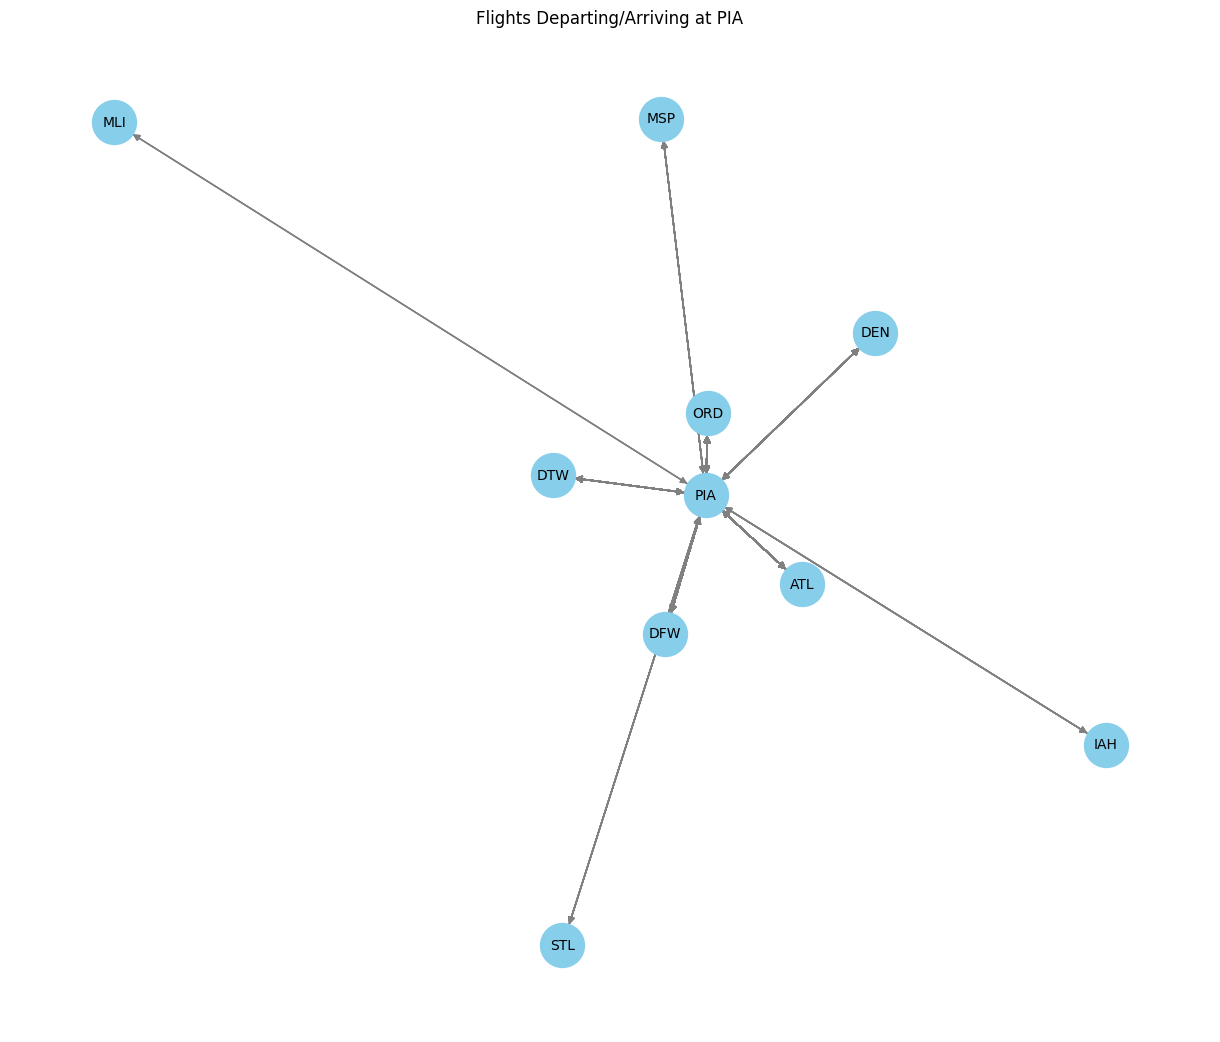

In [18]:
def draw_flights_for_airport(graph, airport_code):
    # Find the unique_id corresponding to the airport_code
    unique_id = None
    for node, data in graph.nodes(data=True):
        if data.get('airport_code') == airport_code:
            unique_id = data.get('unique_id')  # Assuming unique_id is stored in node attributes
            break

    if not unique_id:
        print(f"Airport with code '{airport_code}' not found in the graph!")
        return

    # Collect edges connected to MKE (both inbound and outbound)
    edges = []
    connected_airports = set()

    for edge in graph.edges(keys=True, data=True):
        origin_unique_id = graph.nodes[edge[0]].get('unique_id')
        destination_unique_id = graph.nodes[edge[1]].get('unique_id')

        # Check if either the origin or destination has the same unique_id
        if origin_unique_id == unique_id or destination_unique_id == unique_id:
            edges.append((edge[0], edge[1], edge[2]))  # Include source, target, and edge data

            # Track all connected airports by airport_code (origin and destination)
            if origin_unique_id == unique_id:
                connected_airports.add(graph.nodes[edge[1]]['airport_code'])
            elif destination_unique_id == unique_id:
                connected_airports.add(graph.nodes[edge[0]]['airport_code'])

    if not edges:
        print(f"No edges found for airport code '{airport_code}'")
        return

    # Create a subgraph with the relevant edges and nodes
    subgraph = graph.edge_subgraph(edges).copy()

    # Update node labels to display airport codes (instead of unique_id)
    labels = {
        node: data.get('airport_code', node)
        for node, data in subgraph.nodes(data=True)
    }

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)  # Change layout if needed
    plt.figure(figsize=(12, 10))
    nx.draw(
        subgraph,
        pos,
        with_labels=True,
        labels=labels,  # Use the airport codes as labels
        node_size=1000,
        font_size=10,
        node_color='skyblue',
        edge_color='gray'
    )

    # Optional: Add edge labels (e.g., airline or distance)
    edge_labels = nx.get_edge_attributes(subgraph, 'airline')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)

    # Add title and display
    plt.title(f"Flights Departing/Arriving at {airport_code}")
    plt.show()


# Call the function
draw_flights_for_airport(flightGraph, 'PIA') # Other that work well: LAX, LAS, (ATL has too many Edges & Nodes to show well)

#### Create Visual to Show All Flights & Destination Airports For Specified Airline From Specified Airport

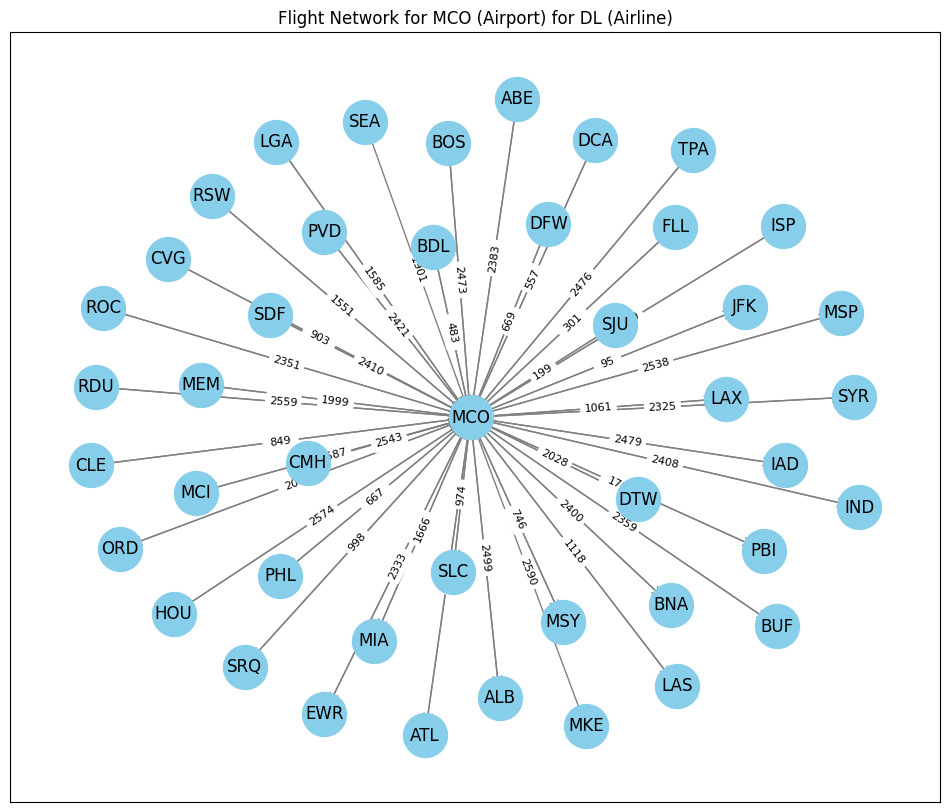

In [19]:
graph_name = 'flights_graph'
airport_collection = 'airports'
edge_collection = 'flights'

def find_edges_for_central_node(central_airport_code, airline_code):
    # Prepare AQL query
    query = f"""
    FOR airport IN {airport_collection}
        FILTER airport.airport_code == @central_airport_code
        FOR edge IN {edge_collection}
            FILTER (edge._from == airport._id OR edge._to == airport._id)
            AND edge.airline_code == @airline_code
        RETURN {{
            edge: edge,
            connected_airport: (
                FOR node IN {airport_collection}
                FILTER node._id == edge._from OR node._id == edge._to
                RETURN node
            )
        }}
    """

    # Execute the query
    cursor = db.aql.execute(query, bind_vars={
        'central_airport_code': central_airport_code,
        'airline_code': airline_code
    })

    # Process results
    results = []
    for result in cursor:
        edge = result['edge']
        connected_airports = result['connected_airport']
        results.append({
            'edge': edge,
            'connected_airports': connected_airports
        })
    return results

def plot_central_flight_graph(edges, central_airport_code):
    # Create a NetworkX graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for result in edges:
        edge = result['edge']
        connected_airports = result['connected_airports']

        # Add nodes for both connected airports
        for airport in connected_airports:
            airport_code = airport['airport_code']
            G.add_node(
                airport_code,
                city_name=airport.get('city_name'),
                state_name=airport.get('state_name')
            )

        # Add edge details
        origin = connected_airports[0]['airport_code']
        destination = connected_airports[1]['airport_code']
        airline_code = edge.get('airline_code')

        G.add_edge(
            origin,
            destination,
            airline_code=airline_code,
            flight_distance=edge.get('flight_distance'),
            flight_number=edge.get('flight_number')
        )

    # Draw the graph
    pos = nx.spring_layout(G)  # Layout for better visualization
    plt.figure(figsize=(12, 10))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="skyblue")
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes})

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray")

    # Add edge labels for flight numbers
    edge_labels = nx.get_edge_attributes(G, 'flight_number')
    nx.draw_networkx_edge_labels(flightGraph, pos, edge_labels=edge_labels, font_size=8)

    # Add a title and show the graph
    plt.title(f"Flight Network for {central_airport_code} (Airport) for {airline_code} (Airline)")
    plt.show()


# Call the function
central_airport_code = 'MCO'
airline_code = 'DL'
edges = find_edges_for_central_node(central_airport_code, airline_code)
plot_central_flight_graph(edges, central_airport_code)

#### Create Visual to Show All Flights & Airports For Airports That Are Located in Specified State

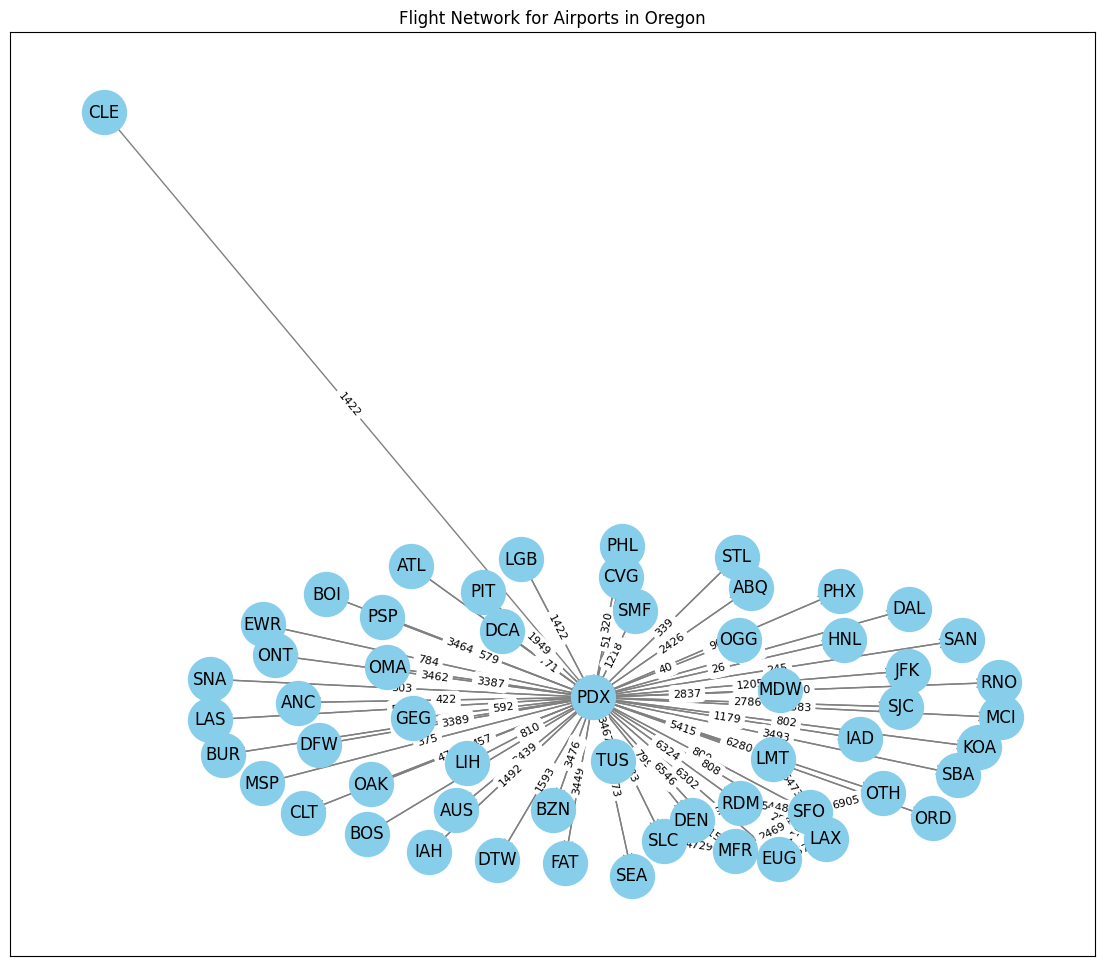

In [20]:
graph_name = 'flights_graph'
airport_collection = 'airports'
edge_collection = 'flights'

def find_edges_by_region(state_name):
    # Prepare AQL query
    query = f"""
    FOR airport IN {airport_collection}
        FILTER airport.state_name == @state_name
        FOR edge IN {edge_collection}
            FILTER edge._from == airport._id OR edge._to == airport._id
        RETURN {{
            edge: edge,
            connected_airport: (
                FOR node IN {airport_collection}
                FILTER node._id == edge._from OR node._id == edge._to
                RETURN node
            )
        }}
    """

    # Execute the query
    cursor = db.aql.execute(query, bind_vars={'state_name': state_name})

    # Process results
    results = []
    for result in cursor:
        edge = result['edge']
        connected_airports = result['connected_airport']
        results.append({
            'edge': edge,
            'connected_airports': connected_airports
        })
    return results

def plot_flight_graph_for_region(edges, region_name):
    # Create a NetworkX graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for result in edges:
        edge = result['edge']
        connected_airports = result['connected_airports']

        # Add nodes for both connected airports
        for airport in connected_airports:
            airport_code = airport['airport_code']
            G.add_node(
                airport_code,
                city_name=airport.get('city_name'),
                state_name=airport.get('state_name')
            )

        # Add edge details
        origin = connected_airports[0]['airport_code']
        destination = connected_airports[1]['airport_code']
        airline_code = edge.get('airline_code')

        G.add_edge(
            origin,
            destination,
            airline_code=airline_code,
            flight_distance=edge.get('flight_distance'),
            flight_number=edge.get('flight_number')
        )

    # Draw the graph
    pos = nx.spring_layout(G)  # Layout for better visualization
    plt.figure(figsize=(14, 12))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="skyblue")
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes})

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray")

    # Add edge labels for flight numbers
    edge_labels = nx.get_edge_attributes(G, 'flight_number')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Add a title and show the graph
    plt.title(f"Flight Network for Airports in {region_name}")
    plt.show()


# Call the function
state_name = 'Oregon' # Others that work well: Mississippi, South Dakota, Ohio, Oklahoma, New Mexico, Oregon
edges = find_edges_by_region(state_name)
plot_flight_graph_for_region(edges, state_name)

#### Create Visualization of All Flights (& Their Corresponding Airports) From All Airports In Specified State

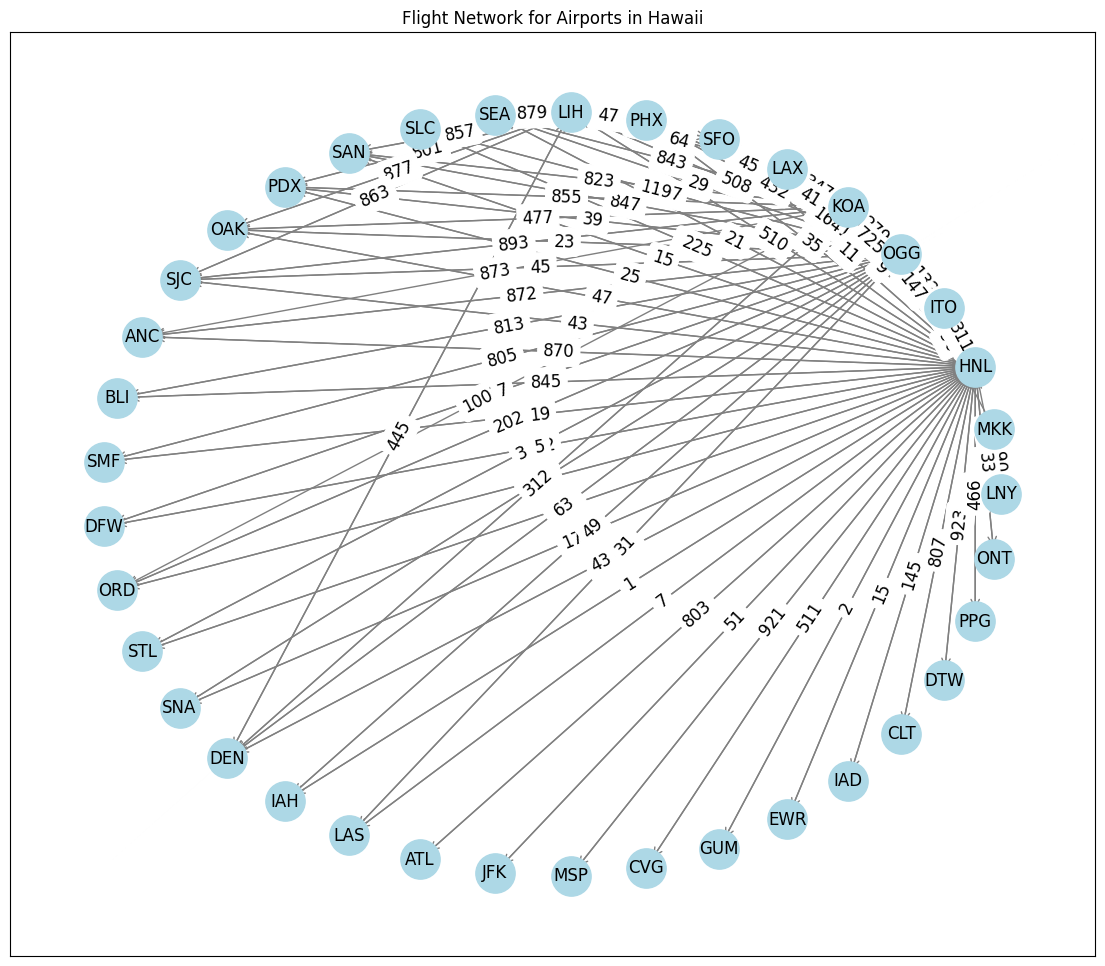

In [21]:
def create_state_flight_subgraph(state_name):
    query = f"""
    FOR airport IN {airport_collection}
        FILTER airport.state_name == @state_name
        LET flights = (
            FOR edge IN {edge_collection}
                FILTER edge._from == airport._id OR edge._to == airport._id
                LET connected_airports = (
                    FOR node IN {airport_collection}
                    FILTER node._id == edge._from OR node._id == edge._to
                    RETURN node
                )
                RETURN {{
                    edge: edge,
                    connected_airports: connected_airports
                }}
        )
        RETURN flights
    """

    # Execute the query
    cursor = db.aql.execute(query, bind_vars={'state_name': state_name})

    # Flatten results
    results = []
    for flight_group in cursor:
        results.extend(flight_group)
    return results

def plot_state_flight_subgraph(edges, state_name):
    G = nx.DiGraph()

    # Add nodes and edges
    for result in edges:
        edge = result['edge']
        connected_airports = result['connected_airports']

        # Add connected airports as nodes
        for airport in connected_airports:
            G.add_node(
                airport['airport_code'],
                city_name=airport.get('city_name'),
                state_name=airport.get('state_name')
            )

        # Add the edge
        origin = connected_airports[0]['airport_code']
        destination = connected_airports[1]['airport_code']
        G.add_edge(
            origin,
            destination,
            airline_code=edge.get('airline_code'),
            flight_distance=edge.get('flight_distance'),
            flight_number=edge.get('flight_number')
        )

    # Visualize the graph
    pos = nx.circular_layout(G)
    plt.figure(figsize=(14, 12))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color="lightblue")
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes})

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray")

    # Add edge labels for flight numbers
    edge_labels = nx.get_edge_attributes(G, 'flight_number')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

    plt.title(f"Flight Network for Airports in {state_name}")
    plt.show()


# Call the function
state_name = "Hawaii" # Others that work well: Nevada, Arkansas, Hawaii
edges = create_state_flight_subgraph(state_name)
plot_state_flight_subgraph(edges, state_name)

#### Create Visualization of All Flights (& Their Corresponding Airports) From Specified For Specific Date Range

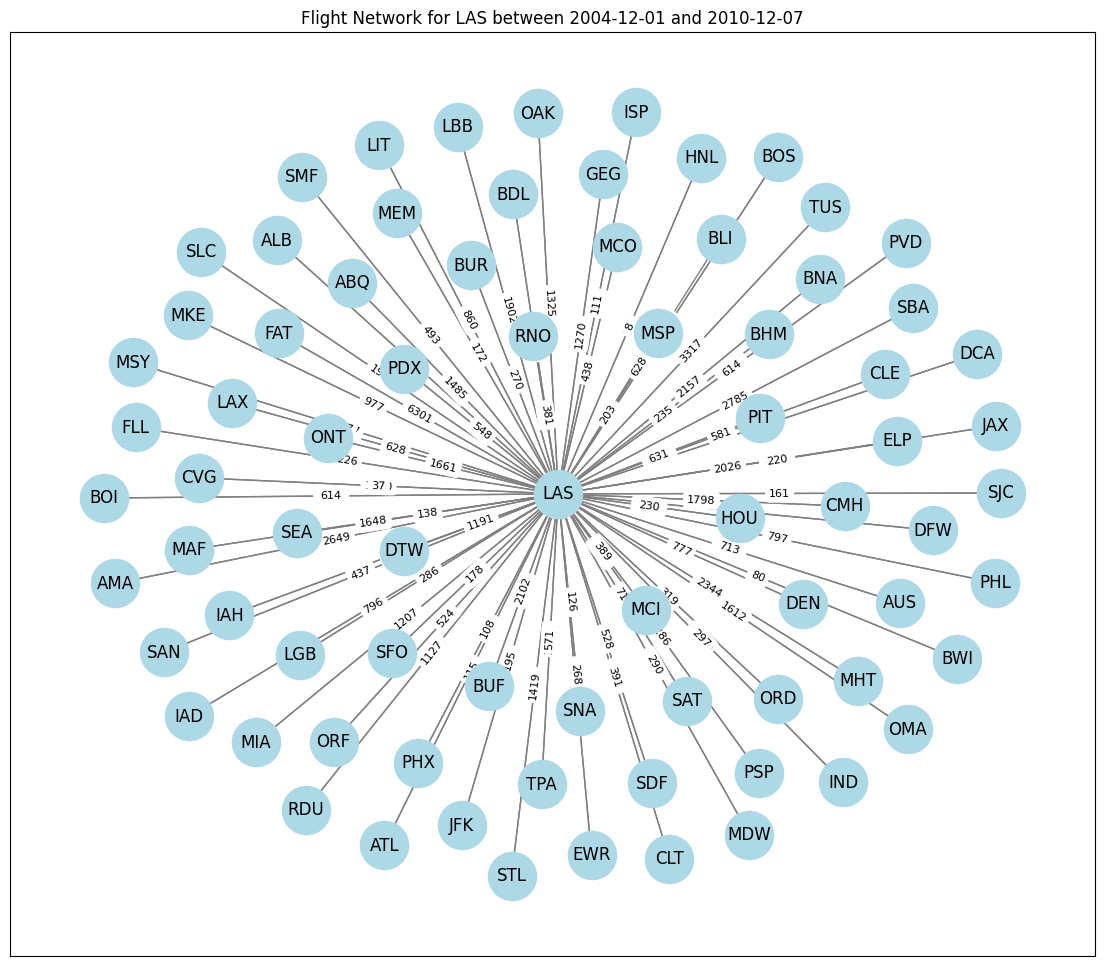

In [22]:
def create_airport_flight_subgraph(airport_code, start_date, end_date):
    query = f"""
    FOR airport IN {airport_collection}
        FILTER airport.airport_code == @airport_code
        LET flights = (
            FOR edge IN {edge_collection}
                FILTER (edge._from == airport._id OR edge._to == airport._id)
                AND edge.departure_datetime >= @start_date
                AND edge.departure_datetime <= @end_date
                LET connected_airports = (
                    FOR node IN {airport_collection}
                    FILTER node._id == edge._from OR node._id == edge._to
                    RETURN node
                )
                RETURN {{
                    edge: edge,
                    connected_airports: connected_airports
                }}
        )
        RETURN flights
    """

    # Execute the query
    cursor = db.aql.execute(query, bind_vars={
        'airport_code': airport_code,
        'start_date': start_date,
        'end_date': end_date
    })

    # Flatten results
    results = []
    for flight_group in cursor:
        results.extend(flight_group)
    return results

def plot_airport_flight_subgraph(edges, airport_code, start_date, end_date):
    G = nx.DiGraph()

    # Add nodes and edges
    for result in edges:
        edge = result['edge']
        connected_airports = result['connected_airports']

        # Add connected airports as nodes
        for airport in connected_airports:
            G.add_node(
                airport['airport_code'],
                city_name=airport.get('city_name'),
                state_name=airport.get('state_name')
            )

        # Add the edge
        origin = connected_airports[0]['airport_code']
        destination = connected_airports[1]['airport_code']
        G.add_edge(
            origin,
            destination,
            airline_code=edge.get('airline_code'),
            flight_distance=edge.get('flight_distance'),
            flight_number=edge.get('flight_number'),
            departure_datetime=edge.get('departure_datetime'),
            arrival_datetime=edge.get('arrival_datetime')
        )

    # Visualize the graph
    pos = nx.spring_layout(G)  # Layout for better visualization
    plt.figure(figsize=(14, 12))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="lightblue")
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes})

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray")

    # Add edge labels for flight numbers and departure times
    edge_labels = nx.get_edge_attributes(G, 'flight_number')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Add a title and show the graph
    plt.title(f"Flight Network for {airport_code} between {start_date} and {end_date}")
    plt.show()


# Call the function
airport_code = 'LAS'
start_date = '2004-12-01'  # Example start date (ISO format)
end_date = '2010-12-07'  # Example end date (ISO format)

edges = create_airport_flight_subgraph(airport_code, start_date, end_date)
plot_airport_flight_subgraph(edges, airport_code, start_date, end_date)

#### Create Visualization of All Flights (& Their Corresponding Airports) From Specified Airports For Specified Day of Week

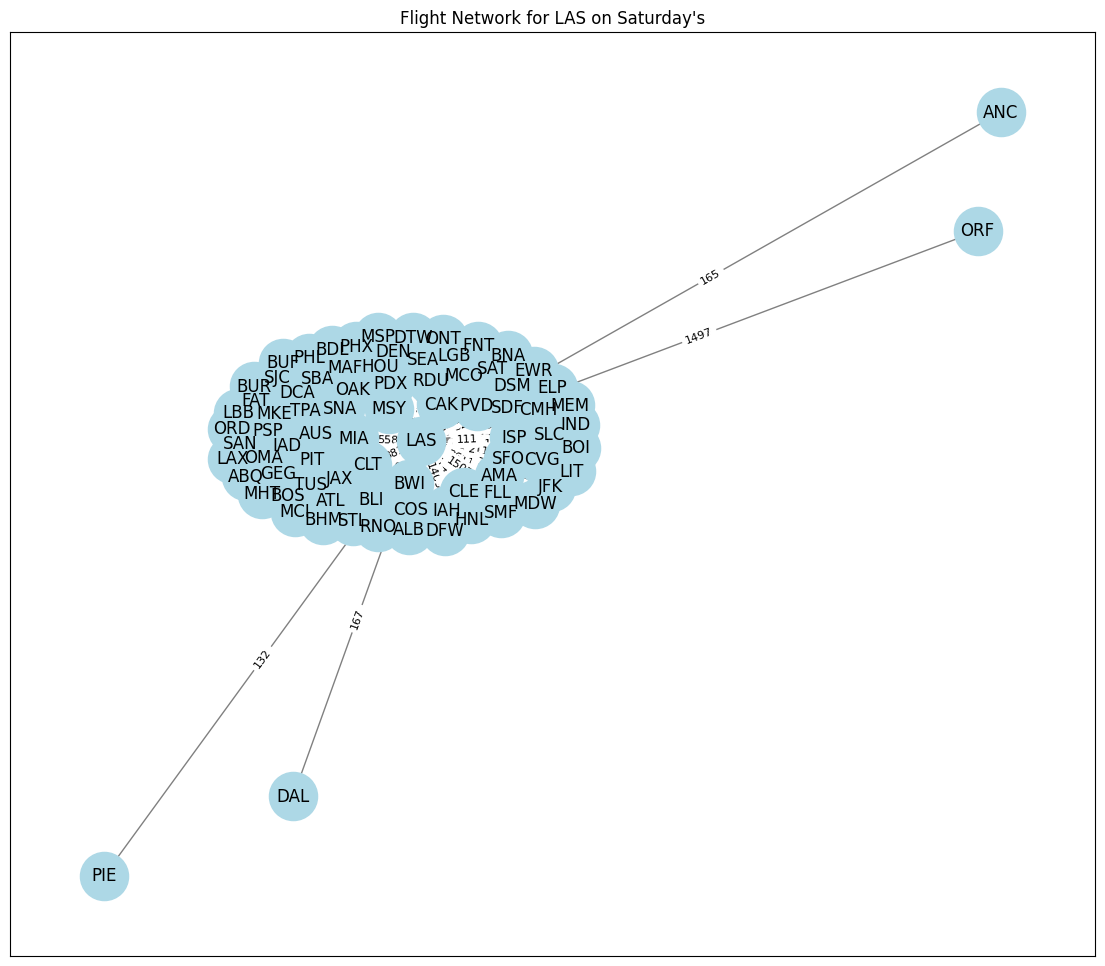

In [23]:
def create_flight_subgraph_by_day(airport_code, day_of_week):
    query = f"""
    FOR airport IN {airport_collection}
        FILTER airport.airport_code == @airport_code
        LET flights = (
            FOR edge IN {edge_collection}
                FILTER (edge._from == airport._id OR edge._to == airport._id)
                AND (DATE_DAYOFWEEK(edge.departure_datetime) == @day_of_week
                     OR DATE_DAYOFWEEK(edge.arrival_datetime) == @day_of_week)
                LET connected_airports = (
                    FOR node IN {airport_collection}
                    FILTER node._id == edge._from OR node._id == edge._to
                    RETURN node
                )
                RETURN {{
                    edge: edge,
                    connected_airports: connected_airports
                }}
        )
        RETURN flights
    """

    # Execute the query
    cursor = db.aql.execute(query, bind_vars={
        'airport_code': airport_code,
        'day_of_week': day_of_week  # 0 for Monday, 6 for Sunday
    })

    # Flatten results
    results = []
    for flight_group in cursor:
        results.extend(flight_group)
    return results

def convert_day_of_week_num_to_name(day_number):
    days = [
        "Monday", 
        "Tuesday", 
        "Wednesday", 
        "Thursday", 
        "Friday", 
        "Saturday", 
        "Sunday"
        ]
    if 0 <= day_number <= 6:
        return days[day_number]
    else:
        raise ValueError("Day number must be between 0 and 6 (inclusive).")
    

def plot_airport_flight_subgraph_by_day(edges, airport_code, day_of_week):
    G = nx.DiGraph()

    # Add nodes and edges
    for result in edges:
        edge = result['edge']
        connected_airports = result['connected_airports']

        # Add connected airports as nodes
        for airport in connected_airports:
            G.add_node(
                airport['airport_code'],
                city_name=airport.get('city_name'),
                state_name=airport.get('state_name')
            )

        # Add the edge
        origin = connected_airports[0]['airport_code']
        destination = connected_airports[1]['airport_code']
        G.add_edge(
            origin,
            destination,
            airline_code=edge.get('airline_code'),
            flight_distance=edge.get('flight_distance'),
            flight_number=edge.get('flight_number'),
            departure_datetime=edge.get('departure_datetime'),
            arrival_datetime=edge.get('arrival_datetime')
        )

    # Visualize the graph
    pos = nx.spring_layout(G)  # Layout for better visualization
    plt.figure(figsize=(14, 12))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="lightblue")
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes})

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray")

    # Add edge labels for flight numbers and departure times
    edge_labels = nx.get_edge_attributes(G, 'flight_number')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Convert day of week from number to text/string
    day_of_week_name = convert_day_of_week_num_to_name(day_of_week)
    
    # Add a title and show the graph
    plt.title(f"Flight Network for {airport_code} on {day_of_week_name}'s")
    plt.show()


# Call the function
airport_code = 'LAS'
day_of_week = 5  # Friday (0=Monday, 6=Sunday)

edges = create_flight_subgraph_by_day(airport_code, day_of_week)
plot_airport_flight_subgraph_by_day(edges, airport_code, day_of_week)


### Summary & Other Notes

- For visualizations, I included some of the airports or state names that I found to work well (that did not have too many flights & airports to show well on the visualization).

### What I learned & Areas for Improvement

- For the visualizations, I should have created a function just for the visualization part so I could reuse it for each example, instead of having to redefine the visualization for each example.